# Taller 3 - Aprendizaje no supervisado

En este taller veremos la aplicación de el método PCA para reducir la dimensionalidad en un problema de alta dimensionalidad, y la aplicación del método de agrupamiento K-means para intentar identificar grupos en un set de datos sin etiquetas.

## Ejercicio 1 - Análisis de componentes principales (PCA)

**Repaso**

En el taller 2 vimos formas de seleccionar variables para tareas de clasificación o regresión. En ese taller, entrenamos un modelo para predecir la clase (en clasificación) o el valor de una variable (en regresión), e identificábamos qué variables son las más relevantes para ello según el modelo.

El PCA es una técnica que nos permite reducir la cantidad de "variables" que usamos, pero con algunas diferencias con los métodos que vimos. Una diferencia importante es que el PCA no nos dice cuáles de las variables originales son más importantes. Lo que hace es generar nuevas variables (los componentes principales o PC), a partir de combinaciones lineales de las variables originales. En particular, estas combinaciones lineales son las que muestran la mayor variabilidad en los datos.

Por ejemplo, podemos aplicar PCA a un set de datos con 100 variables originales, y quedarnos con los primeros 5 componentes principales. Cada uno de los 5 componentes principales va a estar compuesto de muchas de las 100 variables originales, aunque en diferentes combinaciones. Pero luego de aplicar PCA de esta forma, en lugar de una tabla con 100 valores para cada dato, pasaremos a tener una tabla con 5 valores para cada dato.

Esta técnica se utiliza, entre otras cosas, cuando tenemos muchas variables y queremos resumirlas sin perder mucha información (ej. sin necesariamente descartar variables).

### PCA aplicado a test de IQ

Aplicaremos el PCA a los resultados de un test de IQ online, que están disponibles para enseñanza e investigación. No es un test habilitado, pero sirve para nuestros objetivos. Los datos se encuentran en este link:
https://openpsychometrics.org/_rawdata/


In [1]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import re # Biblioteca para realizar emparejamiento de expresiones regulares (hilos de caracteres)

import numpy as np
import numpy.random as rng
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Primero descargamos los datos de una carpeta Dropbox en que los puso un docente, para más fácil acceso. Luego cargamos los datos en la variable X, como solemos hacer, y luego miramos los datos.

In [ ]:
# En este bloque descargamos los datos de una carpeta de Dropbox
!wget -qO iq_data.csv https://www.dropbox.com/s/zap2z5vrt0y1wd2/data.csv?dl=0

In [ ]:
# Aquí cargamos los datos en las variables correspondientes
X = pd.read_csv("iq_data.csv")
# Imprimimos los datos de entrenamiento
print("El tamaño de X es", X.shape)
X.head()

El tamaño de X es (3194, 61)


,VQ1s,VQ1a,VQ1e,VQ2s,VQ2a,VQ2e,VQ3s,VQ3a,VQ3e,VQ4s,...,MQ5s,MQ5a,MQ5e,MQ6s,MQ6a,MQ6e,dateload,introelapse,testelapse,endelapse
0,4,"2,4,3,1",8382,3,"3,2,1",7460,3,"1,4,2",5213,3,...,4,"17,21,18,20",8540,3,"26,23,22",8974,2019-01-11 18:29:36,9,674,40
1,3,"4,3,1",42029,3,"1,2,3",56582,3,"4,1,2",23424,2,...,4,"20,21,17,19",10112,4,"26,71,23,25,24,22",13387,2019-01-11 18:31:22,3,703,46
2,4,"3,4,2,1",24844,2,"1,2",16019,3,"4,2,1",9387,3,...,4,"17,20,21,18",15522,5,"25,24,22,23,26",10198,2019-01-11 18:36:29,2,1627,57
3,4,"4,2,3,1",12188,2,"1,2",13542,3,"2,4,1",9309,2,...,2,"17,68,20,21",8469,3,"70,24,23,22,26",12241,2019-01-11 19:06:54,30,848,95
4,4,"1,4,2,3",9023,1,1,12651,3,"2,4,1",6089,2,...,2,"19,20,18,69",12028,0,"72,22",12396,2019-01-11 19:15:14,4,756,168


Los datos son una tabla donde cada fila tiene las respuestas de una persona al test. Hay 3 categoríás de preguntas, Verbal (7 preguntas), Razonamiento (6 preguntas) y Matemática (6 preguntas), indicadas por las letras V, R y M. Las columnas que terminan en "s" tienen el *score* para la pregunta, y las que terminan en "e" tienen el tiempo que tomó responder en milisegundos.

Extraemos las columnas con los puntajes en la tabla *columnas_puntaje* y las columnas con los tiempos en *columnas_tiempo*.

In [ ]:
#
# para los curiosos:
# re.match (re = Regular Expression, match=coincidencia) es una función de
# búsqueda de patrones (expresiones regulares). Al aplicarse a una cadena
# de texto, devuelve True si el patrón especificado se encuentra en esa cadena.
#
# en el caso de abajo, separamos las columnas de los puntajes buscando el patrón
# ".*s" que significa: cualquier caracter ("."), una cantidad arbitraria de veces (*)
# seguido de una "s". Con esto recuperamos las columnas que terminan en "s", que son
# los scores.
#
# para mas informacion sobre expresiones regulares ver
# https://docs.python.org/3/library/re.html
#
# es una herramienta  bastante complicada pero muy poderosa .
#
columnas_puntaje = [col for col in X.columns if re.match(r".*s$", col)]
columnas_tiempo = [col for col in X.columns if re.match(r"[V,R,M].*e$", col)]

Xpuntaje_crudo = X[columnas_puntaje]
Xtiempo_crudo = X[columnas_tiempo]
print("\nPUNTAJES\n========\n",Xpuntaje_crudo)
print("\n\nTIEMPOS\n=======\n",Xtiempo_crudo)


PUNTAJES
       VQ1s  VQ2s  VQ3s  VQ4s  VQ5s  VQ6s  VQ7s  RQ1s  RQ2s  RQ3s  RQ4s  RQ5s  \
0        4     3     3     3     3     3     3     1     3     3     4     4   
1        3     3     3     2     4     4     3    -1     5     4     3     4   
2        4     2     3     3     3     3     3     1     4     4     4     4   
3        4     2     3     2     3     4     3     3     4     4     4     4   
4        4     1     3     2     3     2     3     0     2     1     4     1   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3189     4     2     3     2     3     4     3    -1     1     1     1     1   
3190     4     1     3     3     3     4     2     2     4     4     5     4   
3191     4     1     3     2     4     4     2     2     3     4     4     4   
3192     4     1     3     2     3     3     3     1     1     1     1     1   
3193     1     1    -1     2     3     3     3     3     4     3     3     4   

      RQ6s  MQ1s  MQ2s  MQ3s

A continuación aplicaremos PCA a los puntajes de las preguntas.

Antes de realizar el análisis, inspeccione los datos visualmente e intente predecir qué variables  deberían ser preponderantes en las componentes más importantes del PCA. Escriba su respuesta abajo.


*Inserte su respuesta aquí*

Primero estandarizamos los datos, dándoles media 0 y desvío estándar 1. Luego aplicamos PCA a los datos estandarizados. Complete el código de abajo para aplicar el PCA.

In [ ]:
#
# Preprocesamiento: comenzamos centrando y normalizando los datos
#
# para eso usamos el objeto estandarizador de datos
#
preproc = StandardScaler()
#
# primero calculamos los parámetros del estandarizador
# estos son media y varianza empíricas de cada columna
#
preproc.fit(Xpuntaje_crudo)
#
# luego aplicamos efectivamente la estandarización
#
Xcentrados = preproc.transform(Xpuntaje_crudo)
#
# transformamos los datos matriciales en un DataFrame de Pandas
#
Xpuntaje = pd.DataFrame(Xcentrados)
#
# como Xcentrados es una matriz "cruda", no tiene nombres
# en las columnas.
# aquí le ponemos nombre a las columnas del DataFrame
#
Xpuntaje.columns = Xpuntaje_crudo.columns
#
#
# finalmente extraemos los componentes principales del set de datos
# -----------------------------
# COMPLETAR CODIGO:
# -----------------------------
#
# 1)  crear el modelo de pca (el modelo se llama PCA)
#     y guardar el resultado en un objeto pca_puntaje
#
# 2)  para ajustar el modelo (pca_puntaje) a los datos (Xpuntaje)
# -----------------------------


A continuación, visualizamos los componentes principales del modelo. Los representamos como una matriz, donde cada fila representa un componente principal, y cada columna es una de las variables originales. Así, se muestra en código de colores el peso de cada variable original para cada componente principal.

In [ ]:
# Graficamos los componentes principales
plt.figure(figsize=(10,10))
plt.matshow(pca_puntaje.components_, cmap='RdBu',  fignum=1)
plt.colorbar()
plt.xticks(range(len(Xpuntaje.columns)), Xpuntaje.columns, rotation=60, ha='left')
plt.yticks(range(pca_puntaje.n_components_), np.arange(pca_puntaje.n_components_)+1)
plt.xlabel("Columna")
plt.ylabel("Componente principal")

NameError: ignored

<Figure size 720x720 with 0 Axes>

Intente interpretar los primeros 3 componentes principales. ¿Qué tendencias en los datos cree que están capturando los mismos? (recuerde que los componentes están en el orden de la cantidad de varianza que explican). Discuta también la interpretabilidad del resto de los componentes principales.

*Inserte su respuesta aquí*

Un elemento importante del análisis de PCA es cuanta varianza explica cada componente principal.

Grafique cuál es la varianza explicada por cada componente principal.

¿Cuántos componentes se requieren para explicar el 80% de la varianza?

In [ ]:
#  extraemos la varianza explicada por cada PC, en porcentaje
#
varianzaExplicada = pca_puntaje.explained_variance_ratio_*100
#
# -----------------------------
# COMPLETAR CODIGO:
# -----------------------------
# 1) graficar la varianza que explica cada componente principal
# Puede usar la función plt.plot (vea la documentación en
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html)
#
# 2) imprimir el vector 'varianzaExplicada' para ver cuantos componentes
#    se requieren para explicar el 80% de la varianza
# -----------------------------


A continuación graficamos los datos, proyectados sobre los primeros 3 componentes principales. ¿Cuánta varianza de los datos capturan estos 3 componentes principales?

*Inserte su respuesta aquí*

In [ ]:
#
# proyectamos (transformamos) los datos sobre
# los dos ejes principales calculados
#
Xpuntaje_pca = pca_puntaje.transform(Xpuntaje)
Xpuntaje_pca = pd.DataFrame(Xpuntaje_pca[:,0:3])
Xpuntaje_pca.columns = ['PC1', 'PC2', 'PC3']
#
grr = pd.plotting.scatter_matrix(Xpuntaje_pca, figsize=(7,7))

**Extra 1.1:** Repita el análisis pero para los **tiempos** en lugar de los puntajes.

In [ ]:
# -----------------------------
# COMPLETAR CODIGO:
# -----------------------------
# Extra 1.1
# -----------------------------


## Ejercicio 2: Clustering aglomerativo para identificar especies

En el taller 2, entrenamos un método de clasificación para identificar especies de pingüinos. Usando un set de datos que incluía la especie, asociamos cada especie con sus características. Supongamos un problema alternativo, donde en una expedición descubrimos una región aislada con varias poblaciones de pingüinos, de especie hasta entonces desconocida (es decir, no conocemos las etiquetas). Sospechamos, sin embargo, que hay más de una especie entre esos pinguinos, probablemente 2 o 3.

Pudimos medir varias características de los pingüinos.

In [2]:
import seaborn as sns
penguins = sns.load_dataset('penguins')
penguins = pd.DataFrame(penguins)

penguins = penguins.dropna() # esta línea es para borrar observaciones que les faltan datos
#
# Deshechamos algunas variables: isla y sexo
#
penguins = penguins.drop('island', axis=1)
penguins = penguins.drop('sex', axis=1)
#
# También separamos las características de la especie, que usaremos luego
#
especie = penguins['species']
penguins = penguins.drop('species', axis=1)
#
# Y vemos la tabla de datos
penguins.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


In [ ]:
#
# Estandarizamos los datos
# este procedimiento es exactamente el mismo que vimos arriba para los puntajes
#
preproc = StandardScaler()
preproc.fit(penguins)
penguinsNorm_matrix = preproc.transform(penguins)
penguinsNorm = pd.DataFrame(penguinsNorm_matrix)
penguinsNorm.columns = penguins.columns
#
penguinsNorm.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,-0.896042,0.780732,-1.426752,-0.568475
1,-0.822788,0.119584,-1.069474,-0.506286
2,-0.676280,0.424729,-0.426373,-1.190361
3,-1.335566,1.085877,-0.569284,-0.941606
4,-0.859415,1.747026,-0.783651,-0.692852


## K-means

Este es un algoritmo de aprendizaje no supervisado para agrupar datos a partir de su similitud.

**Es importante destacar que en este caso, tenemos las etiquetas del dataset de pingüinos, pero NO las usaremos ya que se trata de aplicar un metodo de aprendizaje no supervisado.**

El algoritmo K-means se basa en el cálculo de distancias a centroides. Cada cluster (algomeración, que apuntamos a que esté relacionado a las categorías) está asociado a un centroide, y el objetivo del algoritmo es minimizar la suma de las distancias entre los puntos de data y el centroide del cluster que se le asigna a ese dato.

El parámetro principal de K-means es K, la cantidad de grupos
que _a priori_ creemos que contiene el conjunto de datos.
Esto es algo que en general no sabemos, así que tenemos
que probar con varios y elegir uno de acuerdo a algún criterio.
Aquí empezamos con 3.

In [ ]:
from sklearn.cluster import KMeans

K = 3 # numero de clusters en los cuales queremos agrupar los datos

kmeans = KMeans(K,init='k-means++')
kmeans.fit(penguinsNorm)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

<ipython-input-10-7a5490437b09>:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(C[:,0],C[:,1],color='black',s=tam,cmap=cm.viridis,marker='*')


Text(0.5, 1.0, 'resultado de k-means')

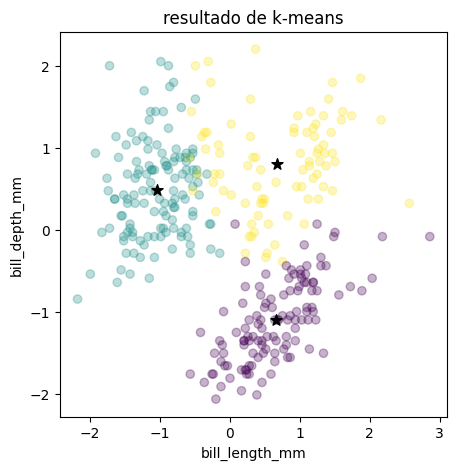

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
#
# mostramos nubes de puntos con grupos asignados por K-means para las
# dos primeras caracteristicas del dataset: bill_length_mm y bill_depth_mm
#
t = kmeans.labels_
C = kmeans.cluster_centers_
K = kmeans.n_clusters
colores = np.arange(K)/(K-1)
tam = 70 # tamaño del centroide en pixeles

plt.figure(figsize=(5,5))
plt.scatter(np.array(penguinsNorm)[:,0], np.array(penguinsNorm)[:,1], c=t/K,cmap=cm.viridis,alpha=0.3)
plt.scatter(C[:,0],C[:,1],color='black',s=tam,cmap=cm.viridis,marker='*')
plt.xlabel(penguinsNorm.bill_length_mm.name)
plt.ylabel(penguinsNorm.bill_depth_mm.name)
plt.title('resultado de k-means')

## Correspondencia entre grupos y clases

Dibuje nuevamente los datos anteriores, esta vez coloreados según la especie.

In [ ]:
#

## Heurística del codo

Una forma de intuir que valor de K es óptimo es prediciendo para bastantes K y buscando el codo. A esto se le llama _heurística_ porque no es un método formal, sino un criterio arbitrario para obtener una respesta.

El _método del codo_ se basa en probar con valores incrementales de K y observar en cada caso cómo mejora el score (es fácil
demostrar que el score _siempre_ crece con K).

Casi siempre, al principio, el score sube rápidamente; esto indica que está bien incrementar K. Sin embargo, llega un punto
en el que incrementar K no resulta en un incremento significativo
del score. A ese punto lo llamamos _codo_ (por cómo se ve en la gráfica). El valor de K correspondiente al codo (el _anterior_ al que ya no produce una mejora significativa) es el que elegimos.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

K 1 score  -1332.0 variación relativa  0%
K 2 score   -552.7 variación relativa 59%
K 3 score   -370.8 variación relativa 33%
K 4 score   -293.9 variación relativa 21%
K 5 score   -228.5 variación relativa 22%
K 6 score   -200.3 variación relativa 12%
K 7 score   -183.1 variación relativa  9%
K 8 score   -166.8 variación relativa  9%
K 9 score   -155.4 variación relativa  7%


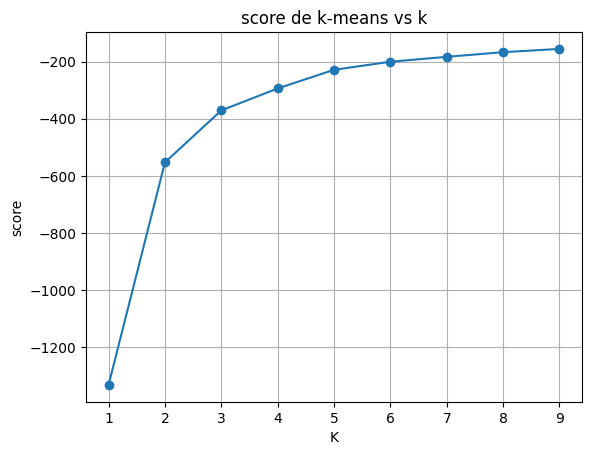

In [ ]:
ks = np.arange(1,10)
scores=list()
for K in ks:
  kmeans = KMeans(n_clusters=K)
  kmeans = kmeans.fit(penguinsNorm)
  score = kmeans.score(penguinsNorm)
  if K > 1:
    var = int(np.round(100*(scores[-1]-score)/scores[-1]))
  else:
    var = 0
  print(f'K {K} score {score:8.1f} variación relativa {var:2d}%')
  scores.append(score)

plt.plot(ks,scores,'o-')
plt.grid(True)
plt.xlabel('K')
plt.ylabel('score')
plt.title('score de k-means vs k')
plt.show()

## Preguntas

* Según el método anterior, cual cree que sería el K óptimo
* Se condice eso con nuestro conocimiento _a priori_ de la cantidad de clases (8)?
* Intente explicar el resultado anterior
